Copyright (c) Microsoft Corporation. All rights reserved.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/regression-part2-automated-ml.png)

## Import Library

In [3]:
from azureml.core import Dataset
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import re
import string
import math
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Import dataset

In [12]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'd61b5034-941c-4a0f-9918-5dcfe01f46fd'
resource_group = 'rg-arjun-ai'
workspace_name = 'ML-arjun'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='twitter_asset')
df = dataset.to_pandas_dataframe()
df

,cl1,cl2,cl3,cl4,cl5,cl6
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1995,0,1468280681,Tue Apr 07 00:43:16 PDT 2009,NO_QUERY,chomma,@roxy_yeah yep a loser.
1996,0,1468280970,Tue Apr 07 00:43:22 PDT 2009,NO_QUERY,EvilSue,and finito! All bathroom contractors been thru...
1997,0,1468281170,Tue Apr 07 00:43:26 PDT 2009,NO_QUERY,lexikitty,@caitlinaudrey awww! that sucks! are you goin...
1998,0,1468281205,Tue Apr 07 00:43:29 PDT 2009,NO_QUERY,terrajen,"Sorry, SF. Rescheduling my SF trip for this co..."


## Data preparation

In [6]:
df.drop(columns=['cl1 ','cl2','cl3','cl4','cl5'], axis=1, inplace=True)

df.rename(columns={'cl6':'Tweets'},inplace=True)

In [7]:
sample_data = df.copy()

In [8]:
sample_data.shape

(2000, 1)

### Defining Functions

In [9]:
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not", "doesn't":"does not","who'll":"who will", "you'll":"you will"}
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [10]:
#remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('http')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [11]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [12]:
sample_data['Tweets'] = sample_data['Tweets'].apply(lambda x: re.sub(r"\S*https?:\S*", "", x)) # remove https links

sample_data['Tweets'] = sample_data['Tweets'].apply(lambda x: re.sub( r'(^|[^@\w])@(\w{1,15})\b', '', x )) # remove usernames

sample_data['Tweets']= sample_data['Tweets'].apply(lambda x:expand_contractions(x)) # replace contractions

sample_data['Tweets']= sample_data['Tweets'].str.lower() # make text lower case

sample_data['Tweets']= sample_data['Tweets'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x)) #remove punctuations

sample_data['Tweets']= sample_data['Tweets'].apply(lambda x: re.sub('W*dw*','',x)) 

sample_data['Tweets']= sample_data['Tweets'].apply(lambda x: remove_stopwords(x)) # remove stopwords

sample_data['Tweets']= sample_data['Tweets'].apply(lambda text: lemmatize_words(text)) # lemmatize words

In [13]:
sia = SentimentIntensityAnalyzer()

In [14]:
sample_data['sentiment_scores'] = sample_data['Tweets'].apply(lambda text: sia.polarity_scores(text))
sample_data['compound_score'] = sample_data['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
sample_data['sentiment'] = sample_data['compound_score'].apply(lambda score: 'Positive' if score > 0 else ("Negative" if score < 0 else "Neutral"))

In [15]:
sample_data.rename(columns={"Tweets": "Reformed_Tweets"}, inplace=True)
sample_data

,Reformed_Tweets,sentiment_scores,compound_score,sentiment
0,awww bummer shoula got avi carr thir ay,"{'neg': 0.271, 'neu': 0.729, 'pos': 0.0, 'comp...",-0.3818,Negative
1,upset cant upate facebook texting might cry re...,"{'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...",-0.7269,Negative
2,ive many time ball manage save 50 rest go bouns,"{'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'comp...",0.4939,Positive
3,whole boy feel itchy like fire,"{'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...",-0.2500,Negative
4,behaving im cant see,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
...,...,...,...,...
1995,yep loser,"{'neg': 0.607, 'neu': 0.0, 'pos': 0.393, 'comp...",-0.2960,Negative
1996,finito bathroom contractor thru house quote in...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1997,awww suck going syney one,"{'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compou...",-0.4404,Negative
1998,sorry sf rescheuling sf trip coming weeken mi ...,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.0772,Negative


In [16]:
df_transform = pd.concat([df,sample_data], axis=1)
df_transform

,Tweets,Reformed_Tweets,sentiment_scores,compound_score,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoula got avi carr thir ay,"{'neg': 0.271, 'neu': 0.729, 'pos': 0.0, 'comp...",-0.3818,Negative
1,is upset that he can't update his Facebook by ...,upset cant upate facebook texting might cry re...,"{'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...",-0.7269,Negative
2,@Kenichan I dived many times for the ball. Man...,ive many time ball manage save 50 rest go bouns,"{'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'comp...",0.4939,Positive
3,my whole body feels itchy and like its on fire,whole boy feel itchy like fire,"{'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...",-0.2500,Negative
4,"@nationwideclass no, it's not behaving at all....",behaving im cant see,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
...,...,...,...,...,...
1995,@roxy_yeah yep a loser.,yep loser,"{'neg': 0.607, 'neu': 0.0, 'pos': 0.393, 'comp...",-0.2960,Negative
1996,and finito! All bathroom contractors been thru...,finito bathroom contractor thru house quote in...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1997,@caitlinaudrey awww! that sucks! are you goin...,awww suck going syney one,"{'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compou...",-0.4404,Negative
1998,"Sorry, SF. Rescheduling my SF trip for this co...",sorry sf rescheuling sf trip coming weeken mi ...,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.0772,Negative


### Visualizations

### 1. Word Cloud

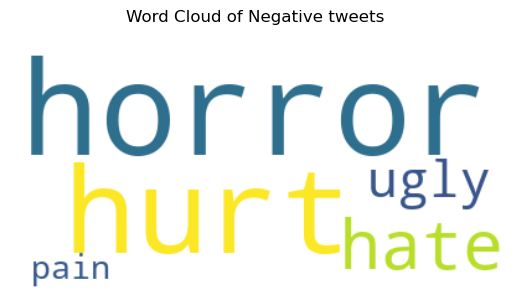

In [19]:
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(negative_text )
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("Word Cloud of Negative tweets \n")
plt.axis("off")
plt.show()

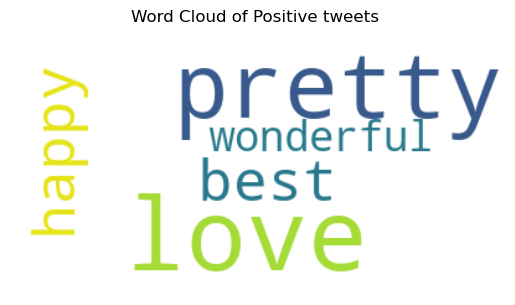

In [20]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(positive_text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("Word Cloud of Positive tweets \n")
plt.axis("off")
plt.show()

#### 2. Histogram

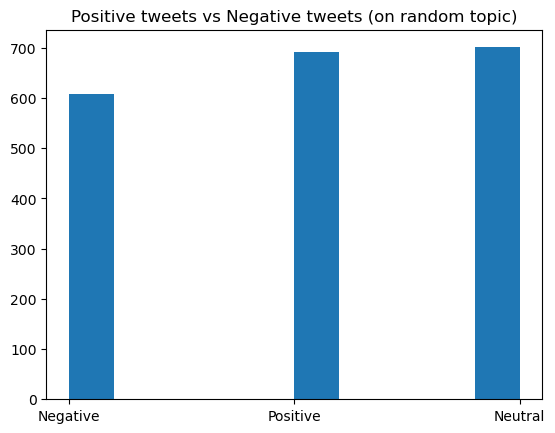

In [21]:
plt.hist(sample_data['sentiment'])
plt.title("Positive tweets vs Negative tweets (on random topic)")
plt.show()

### Saving Transformed data

In [17]:
df_transform.to_csv("output.csv", sep=",", index=False)